In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pip install ucimlrepo

In [30]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)



{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [5]:
print(X.info())
print("\nValores nulos por columna:\n", X.isnull().sum())
print("\nDistribución de la variable objetivo:\n", y.value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB
None

Valores nulos por columna:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

Distribución de la variable 

In [6]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Columnas numéricas:", numeric_features)
print("Columnas categóricas:", categorical_features)

Columnas numéricas: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Columnas categóricas: []


In [7]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [8]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [19]:
# Split data using the binarized target variable
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X, y_bin, test_size=0.2, stratify=y_bin, random_state=42
)

## 1.Cargar y preparar datos (asumiendo que ya se ejecutó el preprocesamiento inicial)

### Convertir problema a binario

In [10]:
y_bin = y['num'].apply(lambda x: 1 if x > 0 else 0)

### Definir variables correctamente

In [21]:
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

### Transformadores

In [22]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

### Preprocesar datos

In [23]:
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

## 2. Función para evaluar modelos

In [24]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    # Ensure y_proba is calculated only if the model has predict_proba
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else [0]*len(y_test)

    # For binary classification, use 'binary' average or no average (which defaults to binary for binary targets)
    # Using binary explicitly for clarity and to prevent future errors if target format changes
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred, average="binary"):.3f}') # Specify average='binary'
    print(f'Recall: {recall_score(y_test, y_pred, average="binary"):.3f}')     # Specify average='binary'
    print(f'F1: {f1_score(y_test, y_pred, average="binary"):.3f}')         # Specify average='binary'
    # roc_auc_score works fine with binary targets directly
    print(f'AUC: {roc_auc_score(y_test, y_proba):.3f}')

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

## 3. Modelos con y sin balanceo y ajuste de hiperparámetros


=== Decision Tree ===

--- Original ---
Mejores parámetros: {'model__max_depth': 5, 'model__min_samples_split': 10}
Accuracy: 0.754
Precision: 0.697
Recall: 0.821
F1: 0.754
AUC: 0.848


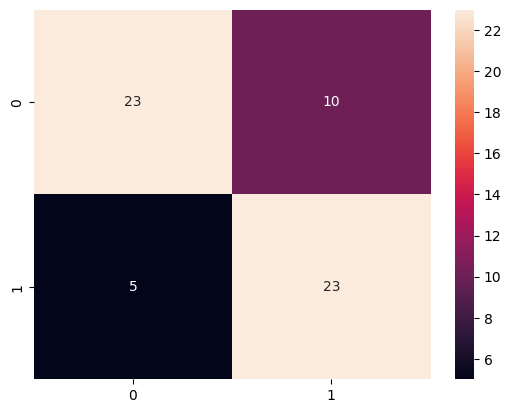

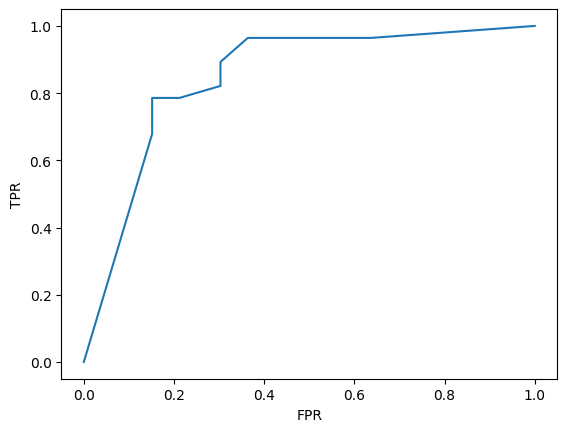


--- SMOTE ---
Mejores parámetros: {'model__max_depth': 3, 'model__min_samples_split': 2}
Accuracy: 0.836
Precision: 0.800
Recall: 0.857
F1: 0.828
AUC: 0.853


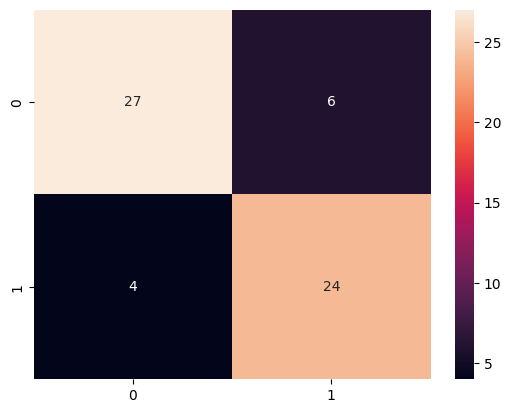

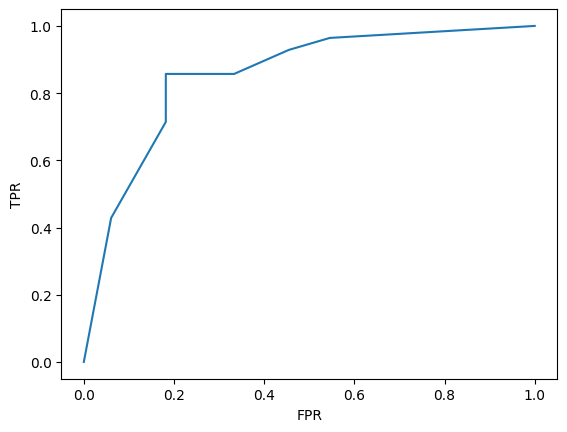


--- Undersampling ---
Mejores parámetros: {'model__max_depth': 7, 'model__min_samples_split': 10}
Accuracy: 0.738
Precision: 0.676
Recall: 0.821
F1: 0.742
AUC: 0.811


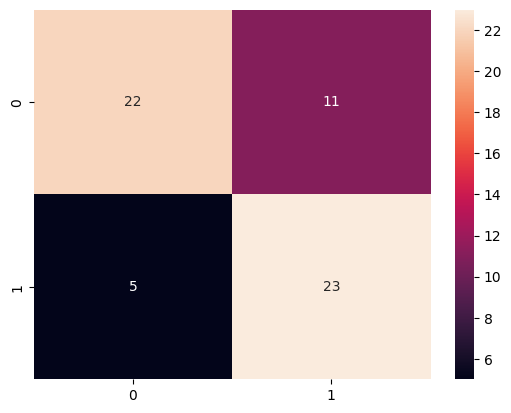

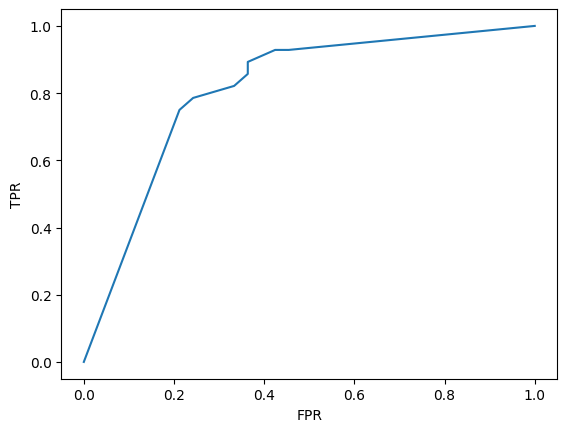


=== Random Forest ===

--- Original ---
Mejores parámetros: {'model__max_depth': 10, 'model__n_estimators': 50}
Accuracy: 0.885
Precision: 0.862
Recall: 0.893
F1: 0.877
AUC: 0.946


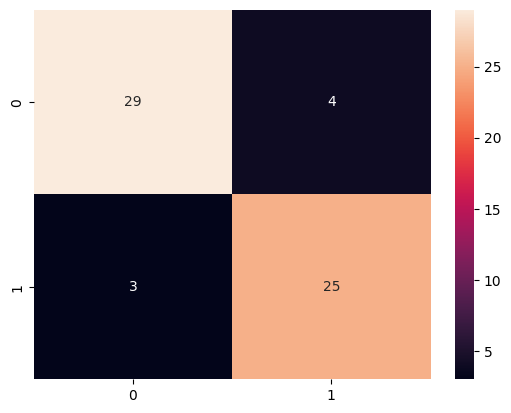

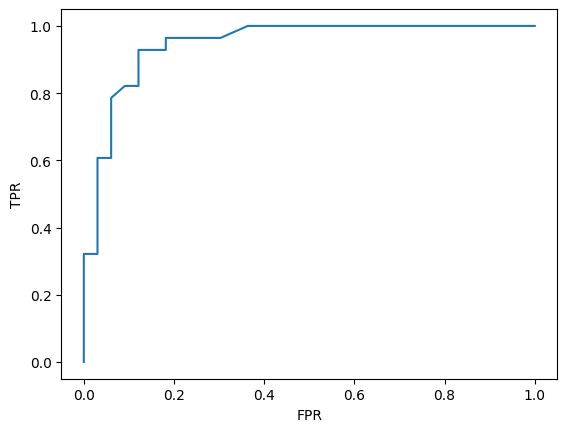


--- SMOTE ---
Mejores parámetros: {'model__max_depth': 5, 'model__n_estimators': 50}
Accuracy: 0.836
Precision: 0.781
Recall: 0.893
F1: 0.833
AUC: 0.942


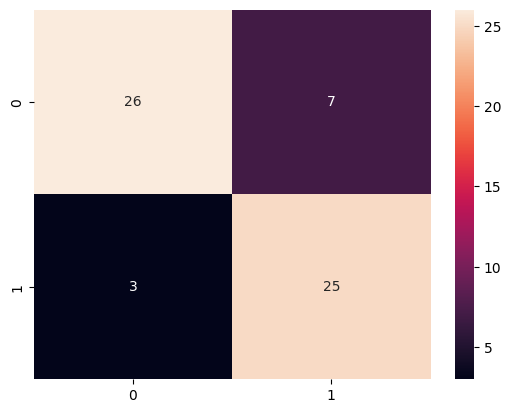

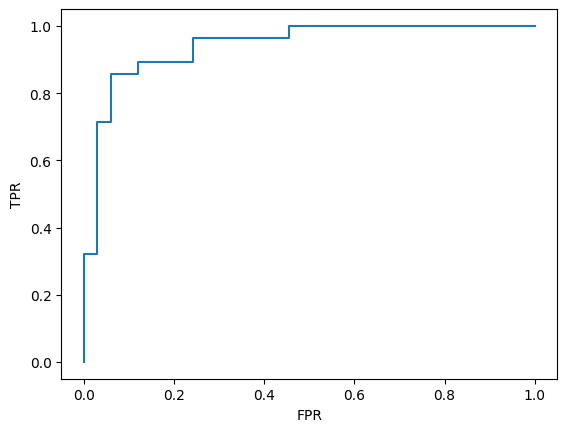


--- Undersampling ---
Mejores parámetros: {'model__max_depth': 10, 'model__n_estimators': 100}
Accuracy: 0.902
Precision: 0.844
Recall: 0.964
F1: 0.900
AUC: 0.934


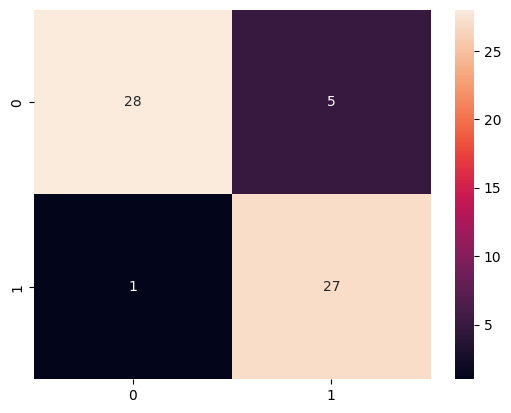

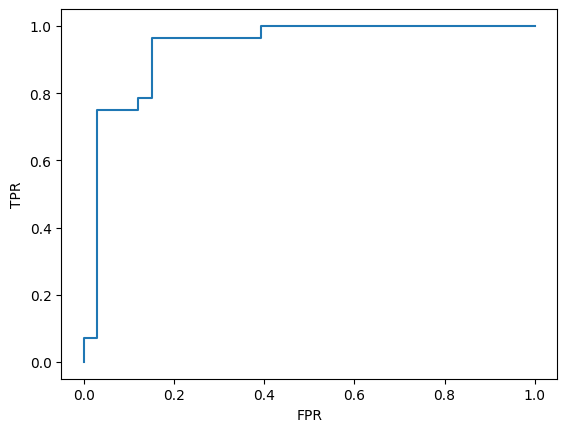


=== AdaBoost ===

--- Original ---
Mejores parámetros: {'model__learning_rate': 1.0, 'model__n_estimators': 50}
Accuracy: 0.885
Precision: 0.818
Recall: 0.964
F1: 0.885
AUC: 0.963


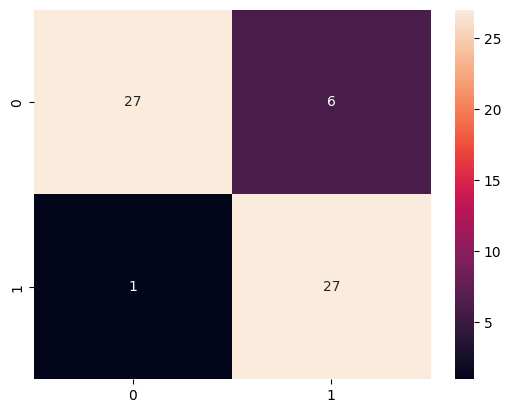

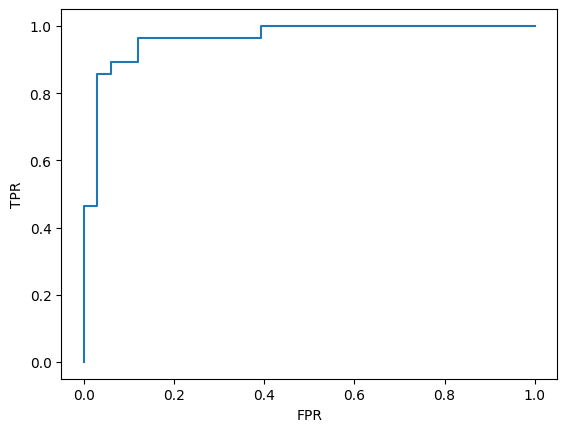


--- SMOTE ---
Mejores parámetros: {'model__learning_rate': 0.8, 'model__n_estimators': 100}
Accuracy: 0.902
Precision: 0.867
Recall: 0.929
F1: 0.897
AUC: 0.972


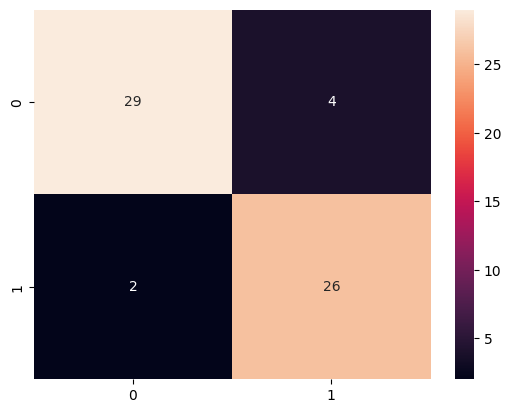

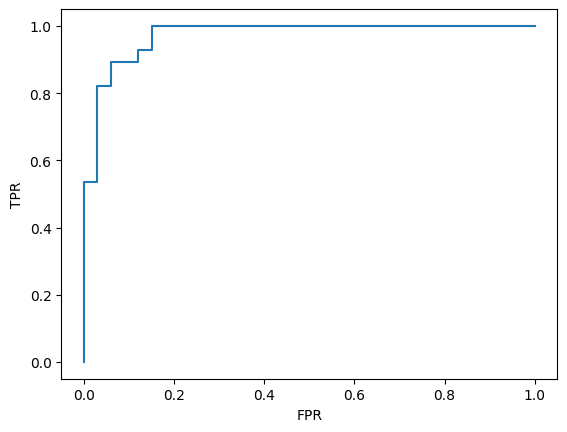


--- Undersampling ---
Mejores parámetros: {'model__learning_rate': 1.0, 'model__n_estimators': 100}
Accuracy: 0.902
Precision: 0.844
Recall: 0.964
F1: 0.900
AUC: 0.962


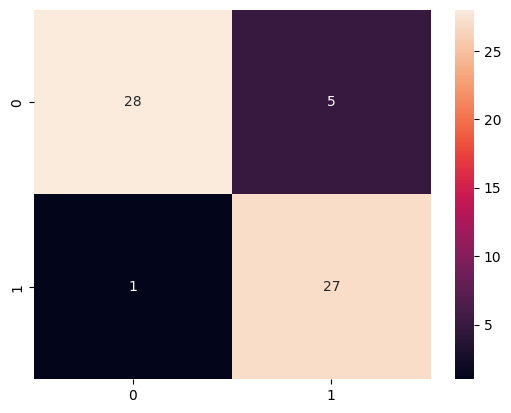

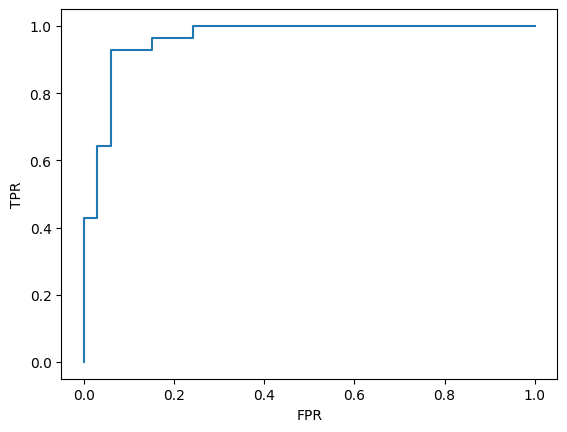

In [28]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

param_grids = {
    'Decision Tree': {'model__max_depth': [3, 5, 7, None], 'model__min_samples_split': [2, 5, 10]},
    'Random Forest': {'model__n_estimators': [50, 100], 'model__max_depth': [5, 10]},
    'AdaBoost': {'model__n_estimators': [50, 100], 'model__learning_rate': [0.8, 1.0]}
}

# Estrategias de balanceo
balance_methods = {
    'Original': None,
    'SMOTE': SMOTE(random_state=42),
    'Undersampling': RandomUnderSampler(random_state=42)
}

# Validación cruzada
cv = StratifiedKFold(n_splits=5)

# Ensure imblearn.pipeline.Pipeline is imported
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SkPipeline # Keep Sklearn's Pipeline for the case without balancer

# Entrenamiento y evaluación
for model_name in models:
    print(f'\n=== {model_name} ===')
    for balance_name, balancer in balance_methods.items():
        print(f'\n--- {balance_name} ---')

        # Pipeline con balanceo
        if balancer:
            # Use imblearn.pipeline.Pipeline when a sampler is an intermediate step
            pipeline_steps = [('balancer', balancer), ('model', models[model_name])]
            pipeline = ImbPipeline(pipeline_steps) # Use ImbPipeline here
        else:
            # Use scikit-learn's Pipeline when only transformers and an estimator are present
            pipeline = SkPipeline([('model', models[model_name])]) # Use SkPipeline here

        # Búsqueda de hiperparámetros
        # Use the binarized training target y_train_bin
        grid = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[model_name],
            cv=cv,
            scoring='f1'
        )
        grid.fit(X_train_pre, y_train_bin)

        # Mejor modelo
        best_model = grid.best_estimator_
        print(f'Mejores parámetros: {grid.best_params_}')
        # Use the binarized testing target y_test_bin for evaluation
        evaluate_model(best_model, X_test_pre, y_test_bin)